In [1]:
from datasets import load_dataset

dataset = load_dataset("solomonk/reddit_mental_health_posts")
df = dataset["train"].to_pandas()

/Users/z5430583/mental-concepcy/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


In [2]:
# nullify the body with these values
df.loc[df["body"].str.lower().isin(["[deleted]", "[removed]", "title"]), "body"] = ""

In [3]:
# combine title and body into text to analyse together
df["text"] = df["title"] + " " + df["body"]

In [4]:
# separate by diagnosis
adhd_df = df[df["subreddit"] == "ADHD"]
asp_df = df[df["subreddit"] == "aspergers"]
dep_df = df[df["subreddit"] == "depression"]
ocd_df = df[df["subreddit"] == "OCD"]
ptsd_df = df[df["subreddit"] == "ptsd"]

In [5]:
import spacy
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import json

# Initialize spaCy model
nlp = spacy.load("en_core_web_sm")


# Define the function for simple Semantic Role Labeling (SRL)
def simple_srl(sentence, nlp):
    sentence = str(sentence)
    doc = nlp(sentence)
    subjects = []
    verbs = []
    objects = []
    indirect_objects = []

    for token in doc:
        if "subj" in token.dep_:
            subjects.append(token.text)
        if "VERB" in token.pos_:
            verbs.append(token.lemma_)
        if "obj" in token.dep_:
            objects.append(token.text)
        if "dative" in token.dep_:
            indirect_objects.append(token.text)

    return {
        "subjects": subjects,
        "verbs": verbs,
        "objects": objects,
        "indirect_objects": indirect_objects,
    }

In [ ]:
# Process each sentence and extract SRL results
srl_results = []
for text in ptsd_df["text"]:  # Change by diagnosis
    result = simple_srl(text, nlp)
    srl_results.append(result)

# Save as JSON
with open("ptsd.json", "w") as f:  # Change by diagnosis
    json.dump(srl_results, f)

In [10]:
# Read from JSON
with open("ocd.json", "r") as f:  # Change by diagnosis
    srl_results = json.load(f)

# Keep set of unique subjects, verbs, objects, and indirect objects
results = []

for d in srl_results:
    unique_subjects = set(word.lower() for word in d["subjects"])
    unique_verbs = set(word.lower() for word in d["verbs"])
    unique_objects = set(word.lower() for word in d["objects"])
    unique_indirect_objects = set(word.lower() for word in d["indirect_objects"])
    results.append(
        {
            "subjects": list(unique_subjects),
            "verbs": list(unique_verbs),
            "objects": list(unique_objects),
            "indirect_objects": list(unique_indirect_objects),
        }
    )

# Save as JSON
with open("ocd_unique.json", "w") as f:  # Change by diagnosis
    json.dump(results, f)

In [15]:
# Remove stop words from the unique subjects, verbs, objects, and indirect objects
from spacy.lang.en.stop_words import STOP_WORDS

# Read from JSON
with open("ptsd_unique.json", "r") as f:  # Change by diagnosis
    srl_results = json.load(f)

# Keep non stop words
results = []

for d in srl_results:
    unique_subjects = set(
        word for word in d["subjects"] if word.lower() not in STOP_WORDS
    )
    unique_verbs = set(word for word in d["verbs"] if word.lower() not in STOP_WORDS)
    unique_objects = set(
        word for word in d["objects"] if word.lower() not in STOP_WORDS
    )
    unique_indirect_objects = set(
        word for word in d["indirect_objects"] if word.lower() not in STOP_WORDS
    )
    results.append(
        {
            "subjects": list(unique_subjects),
            "verbs": list(unique_verbs),
            "objects": list(unique_objects),
            "indirect_objects": list(unique_indirect_objects),
        }
    )

# Save as JSON
with open("ptsd_clean.json", "w") as f:  # Change by diagnosis
    json.dump(results, f)

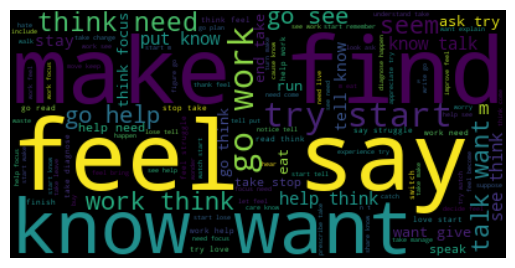

In [17]:
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt

with open("adhd_unique.json", "r") as f:  # Change by diagnosis
    srl_results = json.load(f)

# Combine all values
combined_subject = " ".join(
    value for d in srl_results if "subjects" in d for value in d["verbs"]
)

wordcloud = WordCloud().generate(combined_subject)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [60]:
def build_and_plot_knowledge_graph_pyvis(srl_results, output_file="network.html"):
    G = nx.DiGraph()

    subjects = srl_results["subjects"]
    verbs = srl_results["verbs"]
    objects = srl_results["objects"]
    indirect_objects = srl_results["indirect_objects"]

    for subject in subjects:
        for verb in verbs:
            for obj in objects:
                G.add_edge(subject, obj, label=verb)
            for ind_obj in indirect_objects:
                G.add_edge(subject, ind_obj, label=verb)

    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=50)

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="red",
        node_size=2000,
        font_size=12,
        font_color="black",
        font_weight="bold",
        arrows=True,
    )

    edge_labels = nx.get_edge_attributes(G, "label")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    net = Network()
    net.repulsion()
    net.from_nx(G)
    plt.show()

In [21]:
print(srl_results[0])

{'subjects': ['it', 'that', 'life', 'me', 'worth', 'you', 'i'], 'verbs': ['make', 'fall', '’s', 'cannot', 'know', 'prioritize', 'learn', 'accept', '’m', 'go', 'work', '’', 'focus', 'save', 'prescribe', 'realize', 'wanna', 'take', 'diagnose', 'get', 'waste', 'do', 'feel', 'prove'], 'objects': ['pressure', 'more', 'task', 'hand', 'rant', 'time', 'engineering', 'life', 'dose', 'what', 'day', '24/7', 'fellowship', 'adhd', 'everything', 'something', 'cycle'], 'indirect_objects': []}


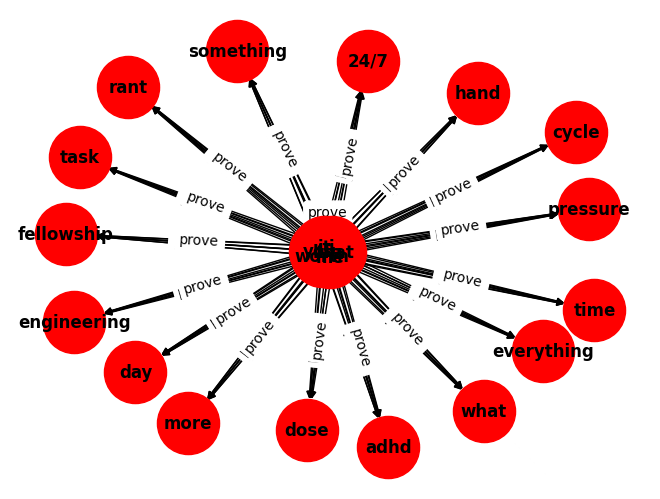

In [61]:
build_and_plot_knowledge_graph_pyvis(srl_results[0], output_file="network.html")